In [ ]:
# homogeneiety analysis 

In [5]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.stats import ks_2samp

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from Bio import SeqIO
from io import StringIO
from Bio.SeqUtils import GC
from statannot import add_stat_annotation 

In [ ]:
## 1. Fig 3e  ----------------

In [2]:
##  prepare the reference 

input_file = '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Figure3/Data/bruno_et_al_2010_tx_loci.fasta'
output_file = '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Figure3/Data/bruno_et_al_2010_tx_loci_output.fasta'

tmp_id_ls = []
tmp_seq_ls = []
with open(output_file, 'w') as output_handle:
    for seqs in SeqIO.parse(open(input_file),'fasta'):
        tmp_id_ls.append(seqs.id)
        tmp_seq_ls.append(str(seqs.seq))

original_seq_df = pd.DataFrame([tmp_id_ls, tmp_seq_ls]).T
original_seq_df = original_seq_df.rename(columns={0: 'gene', 1:'seq'})
original_seq_df.to_csv('/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Figure3/Data/bruno_et_al_2010_tx_loci.txt',sep='\t')

f_annotations = "/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Figure3/Data/bruno_et_al_2010_tx_loci.annotation"
annotation = pd.read_csv(f_annotations,sep='\t')
df = pd.merge(original_seq_df, annotation,how='left',on=['gene','gene'])

In [3]:
def get_window(row):

    start = row['window_start_x']
    end = row['window_end_x']
    
    subseq = row['seq'][int(start):int(end)]
    
    return subseq

/tmp/ipykernel_4032/698419380.py:19: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  aver[['gene','window_start','window_end']] = aver['id'].str.split('_',2,expand = True)
/tmp/ipykernel_4032/698419380.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top['group'] = 'top 1/3'
/tmp/ipykernel_4032/698419380.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bottom['group'] = 'bottom 1/3'
No artists with labels found t

(556, 23)
top 1/3 v.s. bottom 1/3: Mann-Whitney-Wilcoxon test two-sided, P_val=1.831e-02 U_stat=3.418e+04


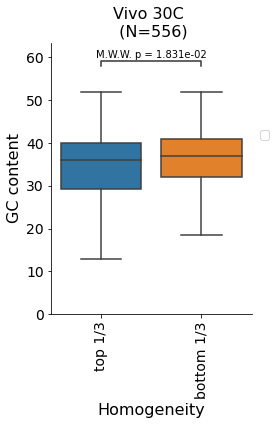

In [6]:
### 30C ----------------------------
### pure condition

dir = '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Figure3/Data/'
pure = pd.read_csv(dir+'homo_pure_allinfo_vivo.txt', sep='\t')
pure.columns 
pure=pure.dropna()
pure['weighted_corr'] = pd.to_numeric(pure['weighted_corr'], errors='coerce')
pure['replicate'] = pd.to_numeric(pure['replicate'], errors='coerce')
pure = pure[(pure['replicate'] == 0) | (pure['replicate'] == 1) | (pure['replicate'] == 2)]
pure['window_start'] = pd.to_numeric(pure['window_start'], errors='coerce')
pure['window_end'] = pd.to_numeric(pure['window_end'], errors='coerce')
pure['window_start'] = pure['window_start'].astype(int)
pure['window_end'] = pure['window_end'].astype(int)
pure['win_length'] = pure['window_end'].astype(int) - pure['window_start'].astype(int)
pure['id'] = pure['gene'] + '_' + pure['window_start'].astype(str)  + '_' + pure['window_end'].astype(str)
aver = pure.groupby(['condition', 'id', 'region'])['weighted_corr'].mean()
aver = aver.reset_index()
aver[['gene','window_start','window_end']] = aver['id'].str.split('_',2,expand = True)
pure=aver

tmp1 = pure[pure['condition'] == '30C']
tmp2 = pure[pure['condition'] == '37C']

df_merge = pd.merge(tmp1,tmp2,how='inner',on=['id','id'])
quan1 = 2/3
diff1 = df_merge['weighted_corr_x'].quantile(q=quan1)
quan2 = 1/3
diff2 = df_merge['weighted_corr_x'].quantile(q=quan2)

top = df_merge[df_merge['weighted_corr_x'] >= diff1]
top['group'] = 'top 1/3'
bottom = df_merge[df_merge['weighted_corr_x'] <= diff2]
bottom['group'] = 'bottom 1/3'
combine = pd.concat([top,bottom],ignore_index=True)
combine['gene'] = combine['gene_x']

### integrate with seq
dplot = pd.merge(combine,df,how='left',on=['gene','gene']) 
dplot['window_seq'] = dplot.apply(get_window,axis=1)

dplot = dplot.drop_duplicates()
dplot['window_seq'] = dplot['window_seq'].astype(str)
dplot['GC_window_seq'] = dplot['window_seq'].apply(GC)

print(dplot.shape) 


### plots------------------

plt.figure(figsize=(3.6,5))

ax = sns.boxplot(data=dplot, x='group',y='GC_window_seq', showfliers = False, dodge=False)  # order = order
plt.title('Vivo 30C \n (N='+str(len(dplot.id.unique()))+')',fontsize = 16)
plt.xlabel('Homogeneity',fontsize = 16) 
plt.ylabel('GC content',fontsize = 16)
plt.xticks(fontsize = 14,rotation=90) 
plt.yticks(fontsize = 14) 
plt.ylim(0,60)
plt.legend(loc='best', bbox_to_anchor=(1.01, 0.7),prop={'size': 12})
ax.spines[['right', 'top']].set_visible(False) 

add_stat_annotation(ax, data=dplot, x='group',y='GC_window_seq', 
                    box_pairs = [("top 1/3", "bottom 1/3")],
                    comparisons_correction = None,
                    test="Mann-Whitney",text_format='full', loc='inside', line_offset_to_box=0.1, verbose=3)  

dir_out = '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Figure3/Data/'
plt.savefig(dir_out+'Fig3e_vivo_GC_30C.pdf',bbox_inches='tight', dpi=300) 

/tmp/ipykernel_4032/1228257362.py:19: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  aver[['gene','window_start','window_end']] = aver['id'].str.split('_',2,expand = True)
/tmp/ipykernel_4032/1228257362.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top['group'] = 'top 1/3'
/tmp/ipykernel_4032/1228257362.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bottom['group'] = 'bottom 1/3'
No artists with labels foun

(556, 23)
top 1/3 v.s. bottom 1/3: Mann-Whitney-Wilcoxon test two-sided, P_val=8.467e-05 U_stat=3.120e+04


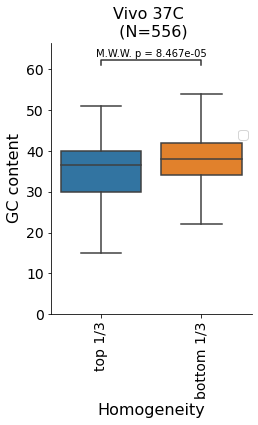

In [9]:
### 37C------------------------
### pure condition

dir = '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Figure3/Data/'
pure = pd.read_csv(dir+'homo_pure_allinfo_vivo.txt', sep='\t')
pure.columns 
pure=pure.dropna()
pure['weighted_corr'] = pd.to_numeric(pure['weighted_corr'], errors='coerce')
pure['replicate'] = pd.to_numeric(pure['replicate'], errors='coerce')
pure = pure[(pure['replicate'] == 0) | (pure['replicate'] == 1) | (pure['replicate'] == 2)]
pure['window_start'] = pd.to_numeric(pure['window_start'], errors='coerce')
pure['window_end'] = pd.to_numeric(pure['window_end'], errors='coerce')
pure['window_start'] = pure['window_start'].astype(int)
pure['window_end'] = pure['window_end'].astype(int)
pure['win_length'] = pure['window_end'].astype(int) - pure['window_start'].astype(int)
pure['id'] = pure['gene'] + '_' + pure['window_start'].astype(str)  + '_' + pure['window_end'].astype(str)
aver = pure.groupby(['condition', 'id', 'region'])['weighted_corr'].mean()
aver = aver.reset_index()
aver[['gene','window_start','window_end']] = aver['id'].str.split('_',2,expand = True)
pure=aver

tmp1 = pure[pure['condition'] == '30C']
tmp2 = pure[pure['condition'] == '37C']

df_merge = pd.merge(tmp1,tmp2,how='inner',on=['id','id'])
quan1 = 2/3
diff1 = df_merge['weighted_corr_y'].quantile(q=quan1)
quan2 = 1/3
diff2 = df_merge['weighted_corr_y'].quantile(q=quan2)

top = df_merge[df_merge['weighted_corr_y'] >= diff1]
top['group'] = 'top 1/3'
bottom = df_merge[df_merge['weighted_corr_y'] <= diff2]
bottom['group'] = 'bottom 1/3'
combine = pd.concat([top,bottom],ignore_index=True)
combine['gene'] = combine['gene_x']


### integrate with seq
dplot = pd.merge(combine,df,how='left',on=['gene','gene']) 
dplot['window_seq'] = dplot.apply(get_window,axis=1)

dplot = dplot.drop_duplicates()
dplot['window_seq'] = dplot['window_seq'].astype(str)
dplot['GC_window_seq'] = dplot['window_seq'].apply(GC)

print(dplot.shape)


### plot--------------------------

plt.figure(figsize=(3.6,5))

ax = sns.boxplot(data=dplot, x='group',y='GC_window_seq', showfliers = False, dodge=False)  # order = order
plt.title('Vivo 37C \n (N='+str(len(dplot.id.unique()))+')',fontsize = 16)
plt.xlabel('Homogeneity',fontsize = 16) 
plt.ylabel('GC content',fontsize = 16)
plt.xticks(fontsize = 14,rotation=90) 
plt.yticks(fontsize = 14) 
plt.ylim(0,60)
plt.legend(loc='best', bbox_to_anchor=(1.01, 0.7),prop={'size': 12})
ax.spines[['right', 'top']].set_visible(False) 


add_stat_annotation(ax, data=dplot, x='group',y='GC_window_seq', 
                    box_pairs = [("top 1/3", "bottom 1/3")],
                    comparisons_correction = None,
                    test="Mann-Whitney",text_format='full', loc='inside', line_offset_to_box=0.1, verbose=3) 

dir_out = '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Figure3/Data/'
plt.savefig(dir_out+'Fig3e_vivo_GC_37C.pdf',bbox_inches='tight', dpi=300) 